### Usage

The required **input** to use this library is a set of objects, each with a set of scalar values, represented as a dictionary. For example:

```json
measurements = {
    't0' : [0.13, 0.21, 0.18, 0.12 ],
    't1' : [0.30, 0.33, 0.28 ],
    't1' : [0.32, 0.31, 0.38, 0.32, 0.37, 0.32 ],
    ...
}
```

For the purpose of demonstration, we simulate the measurement values by sampling from normal distribution. To this end, the module ``MeasurementsSimulator`` can be used. In the following example, we create 4 objects with measurements simulated from two normal distributions differing in mean and standard deviation.

In [2]:
from partial_ranker import MeasurementsSimulator

#Normal distribution 1
n1 = [0.3,0.01] # [mean1, std1]

#Normal distribution 2
n2 = [0.35,0.01] # [mean2, std2]

M = {}
M['t0']  = n1
M['t1']  = n1
M['t2']  = n1
M['t3']  = n2

ms = MeasurementsSimulator(M,seed=3)
ms.measure(reps=5)
measurements = ms.get_measurements()

for m,v in measurements.items():
    print(f'{m}:{v}')

t0:[0.3178862847343032, 0.3043650985051199, 0.3009649746807201, 0.2813650729663551, 0.297226117974856]
t1:[0.2964524102073101, 0.29917258518517537, 0.2937299932317615, 0.2995618183102407, 0.29522781969640494]
t2:[0.2868613524663732, 0.3088462238049958, 0.3088131804220753, 0.31709573063652946, 0.3005003364217686]
t3:[0.3459532258539911, 0.3445464005238047, 0.3345352268441703, 0.35982367434258156, 0.33898932369888524]


#### Visualizing the Measurements

The set of measurements for each object can be visualized as a box-plot using the module ``MeasurementsVisualizer``.

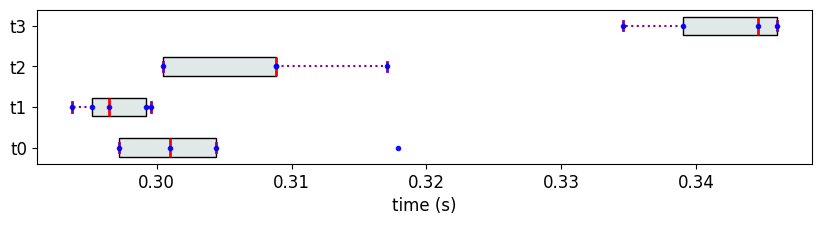

In [3]:
from partial_ranker import MeasurementsVisualizer
mv = MeasurementsVisualizer(measurements)
fig = mv.show_measurements_boxplots(scale=0.5)

The box represents the Inter Quartlie Interval (IQI), which is the interval between the 25th and the 75th quantile values, and the red line with the box represents the median value.

#### The Comparison Matrix

The comparison matrix (**C**) is a square matrix of size $(N \times N)$, where $N$ is the number of objects. This matrix holds the results of pair-wise comparisons among the objects as follows:
        
- If ``t_i`` is better than ``t_j``, then ``C[t_i][t_j] = 0``.  
- If ``t_i`` is equivalent to ``t_j``, then ``C[t_i][t_j] = 1``.
- If ``t_i`` is worse than ``t_j``, then ``C[t_i][t_j] = 2``.

The module ``QuantileComparer`` implements the *better-than* relation by comparing the IOIs; ``t_i`` is considered to be better than ``t_j`` if and only if the IOI of ``t_i`` lies entirely to the left of the IOI of ``t_j``. If the IQI of ``t_i`` and ``t_j`` overlap with one another, then ``t_i`` and ``t_j`` are considered equivalent or incomparable.

The comparison matrix for the samples of measurements is shown below:

In [4]:
from partial_ranker import QuantileComparer
import pandas as pd

cm = QuantileComparer(measurements)
cm.compute_quantiles(q_max=75, q_min=25)
cm.compare()
pd.DataFrame(cm.get_comparison_matrix())


,t0,t1,t2,t3
t0,-1,1,1,2
t1,1,-1,2,2
t2,1,0,-1,2
t3,0,0,0,-1


#### Partial Ranking of the Objects

The module ``PartialRanker`` takes as input the object holding the comparison matrix, in our case - ``QuantileComparer``, and assigns a partial rank to the objects.

In [5]:
from partial_ranker import PartialRanker

pr = PartialRanker(cm)
pr.compute_ranks()

R = pr.get_ranks()
for k,v in R.items():
    print(f'Rank {k}: {v}')

Rank 0: ['t1', 't0', 't2']
Rank 1: ['t3']


Notice that the objects **t0**, **t1** and **t2**, which were sampled from the same distribution, are grouped in the same rank despite the IQI of **t1** and **t2** not overlapping with one another. As mentioned earlier, non-transitivity of the better-than relation leads to more than one reasonable partial rankings, and it is also possible to **not** have **t1** and **t2** in the same rank. This can be achieved by changing the methodology of the parital ranking.

At the moment, three different methodologies for partial ranking described in the [paper](https://arxiv.org/abs/2405.18259) are implemented in this library. They are:

- **PartialRankerDFG** (Methodology 1)
- **PartialRankerDFGReduced** (Methodology 2)
- **PartialRankerMin** (Methodology 3)

If the methodology is not explicitly specified, **PartialRankerDFGReduced** would be used.

Partial ranks according to **PartialRankerDFG**:

In [6]:
from partial_ranker import Method

pr.compute_ranks(Method.DFG)

R = pr.get_ranks()
for k,v in R.items():
    print(f'Rank {k}: {v}')

Rank 0: ['t0', 't1']
Rank 1: ['t2']
Rank 2: ['t3']


Partial ranks according to **PartialRankerMin**:

In [7]:
pr.compute_ranks(Method.Min)

R = pr.get_ranks()
for k,v in R.items():
    print(f'Rank {k}: {v}')

Rank 0: {'t1', 't0', 't2'}
Rank 1: {'t3'}



 In the following section, the behaviour of the different methodologies are demonstrated. In a later section, a couple of experiments to demonstrate the applications of partial ranking have been documented. 